# Equilibration of FOCI-OpenIFS

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [23]:
from dask.distributed import Client, LocalCluster, wait

In [24]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44953 instead
  expected, actual


In [25]:
client

Client Scheduler: tcp://127.0.0.1:46119 Dashboard: http://127.0.0.1:44953/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [26]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [27]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

# Read data

In [28]:
exp_list = ['FOCI_GJK001','FOCI_GJK006']

In [33]:
# NEMO TOP
ds_top_all = []
for exp in exp_list:
    
    chunks = {'x':None, 'y':None, 'deptht': None, 'time_counter': 1} 
    
    top = '%s/%s/outdata/nemo/1y/*1y*ptrc_T.nc' % (esmdir,exp)
    ds_top = xr.open_mfdataset(top,combine='nested', 
                               concat_dim="time_counter", chunks=chunks,
                               decode_timedelta=False,
                               data_vars='minimal', coords='minimal', compat='override',
                               parallel=True).rename({'time_counter':'time', 'nav_lat':'lat', 'nav_lon':'lon'})
    ds_top_all.append(ds_top)

In [34]:
ds_top

<xarray.Dataset>
Dimensions:            (time: 1300, bnds: 2, y: 511, x: 722, deptht: 46)
Coordinates:
  * time               (time) object 2850-07-01 06:00:00 ... 4149-07-01 06:00:00
    lon                (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    lat                (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds, y, x
Data variables:
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bnds        (deptht, bnds) float32 dask.array<chunksize=(46, 2), meta=np.ndarray>
    votrcage           (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         FOCI_GJK006_1m_28500101_28591231_ptrc_T
    description:  transient tracers
    title:        transient tracers
    timeStamp:    2022-Jul-12 18:23:10 GMT
    uuid:         320c507f-baf6-41cf-8152-13b8155c40e5
    history:      Wed Aug 24 18:24:08 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [35]:
ds_top = xr.concat(ds_top_all, dim='time')

# Global mean age tracer

Depth = 300 
Depth = 700 
Depth = 1500 
Depth = 3000 


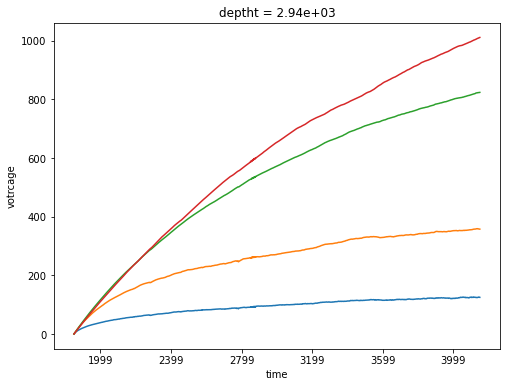

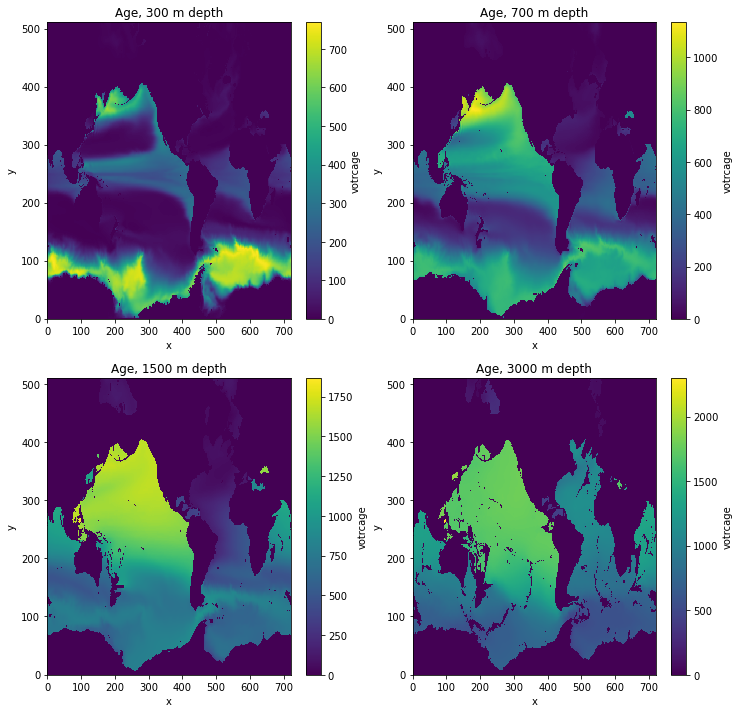

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

fig2, ax2 = plt.subplots(2,2,figsize=(12,12))
axs2 = ax2.flat

scale = 1. / (1e9 * 86400 * 365)

#for i in range(0,len(exp_list)):
if 1:
    #ds_top = ds_top_all[i]
    
    j = 0
    for dep in [300,700,1500,3000]:
        
        # Age tracer
        print('Depth = %d ' % (dep,))
        
        # this is timedelta array
        trage = ds_top['votrcage'].sel(deptht=dep,method='nearest') 
        
        # divide by 365
        trage_float = trage / 365.
        
        # Plot last time steps
        trage_float[-1,:,:].plot(ax=axs2[j])
        axs2[j].set_title('Age, %d m depth' % (dep,))
        
        # Weighted global mean
        trage_wgt = trage_float.where(da_orca05_mask == 1).weighted(da_orca05_area)
        trage_mean = trage_wgt.mean(('x','y'))
        trage_mean.plot(ax=ax,label='%d' % (dep,))
        
        j = j+1

#ax.legend()
#ax.set_ylabel('Global-mean water age [years]')
#ax.set_title('Equilibration of FOCI-OpenIFS')
#fig.tight_layout()
#fig2.tight_layout()
#fig.savefig('equilibration_tracer_age.pdf',format='pdf')